In [1]:
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from natsort import natsorted
from tqdm import tqdm
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
Image.MAX_IMAGE_PIXELS = None
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def build_model():
    model = smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, encoder_depth=5,
                                  decoder_channels=512, activation=None, in_channels=3, classes=13)
    model.to(device)  # move model to gpu
    return model

In [4]:
test_transforms = A.Compose([ToTensorV2()])  #just convert to tensor

class TestDataSet(Dataset):
    # initialize imagepath, transforms:
    def __init__(self, image_paths: list, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    # define main function to read image and label, apply transform function and return the transformed images.
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if self.transforms is not None:  # albumentations
            transformed = self.transforms(image=image)
            image = transformed['image']
        return image, image_path # return tensors of equal dtype and size
        # image is size 3x1024x1024 and mask and bin_mask is size 1x1024x1024 (need dummy dimension to match dimension)

# define dataloading function to use above dataset to return train and val dataloaders:
def load_test_dataset():
    test_dataset = TestDataSet(image_paths=test_images, transforms=test_transforms)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, num_workers=0, pin_memory=True, shuffle=False)
    return test_dataloader  # return train and val dataloaders

In [7]:
model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [8]:
data_src = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set"
model_pth = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50\best_epoch-05.pt"
model = build_model()
model.load_state_dict(torch.load(model_pth))
model.eval()
model.encoder.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), dilation=(2, 2), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), dilation=(2, 2), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), dilation=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), dilation=(2, 2), bias=False)
    (bn1): BatchNorm

In [9]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

In [140]:
image_path = os.path.join(data_src, "he_tiles")
mask_path = os.path.join(data_src, "mask_tiles")
bin_mask_path = os.path.join(data_src, "bin_mask_tiles")
test_images = natsorted([os.path.join(image_path, x) for x in os.listdir(image_path) if x.endswith(".png")])[0:1] # just one image for test for now, change this for different images
test_dataloader = load_test_dataset()

In [141]:
@torch.no_grad()  #decorator to disable gradient calc
def return_image_mask(model, dataloader, device):
    weight_dir = r"C:\Users\Kevin\PycharmProjects\wsi_analysis\kevin\skin_morphometric_analysis\deeplab_pytorch\model\DeepLabV3+_baseline_resnet50"
    model_path = os.path.join(weight_dir, "best_epoch-0{}.pt".format(1))
    model.load_state_dict(torch.load(model_path))  #load model weights
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Inference', colour='red')
    for idx, (images, image_path) in pbar:
        model.eval()  # eval stage
        images = images.to(device, dtype=torch.float)  #move tensor to gpu
        prediction = model(images)
        prediction = torch.nn.functional.softmax(prediction, dim=1).cpu() #softmax for multiclass

    return prediction, image_path

In [142]:
prediction, image_path = return_image_mask(model,test_dataloader,device)

Inference: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


In [143]:
rgb_img = np.array(Image.open(image_path[0]))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]) #imagenet mean/std

In [160]:
he_mask = prediction[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
# {"corneum" : 1,"spinosum": 2,"hairshaft":3,"hairfollicle":4,"smoothmuscle":5,"oil":6,"sweat":7,"nerve":8,"bloodvessel":9,"ecm":10,"fat":11,"white/background":12}
class_category = 12 # in this image, try 1=corneum, 2= spinosum, #10 = ecm, #12 = background, it sees oil and sweat reverse, so this is a misclassification.
he_mask_float = np.float32(he_mask == class_category)
targets = [SemanticSegmentationTarget(class_category, he_mask_float)]
target_layers = [model.encoder.layer4]

In [161]:
# HiResCAM/LayerCAM/GradCAMElementWise works great(everything else is terrible)
CAMmethod = "GradCAMElementWise"
with GradCAMElementWise(model = model, target_layers = target_layers, use_cuda = torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=input_tensor,targets=targets)[0,:]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

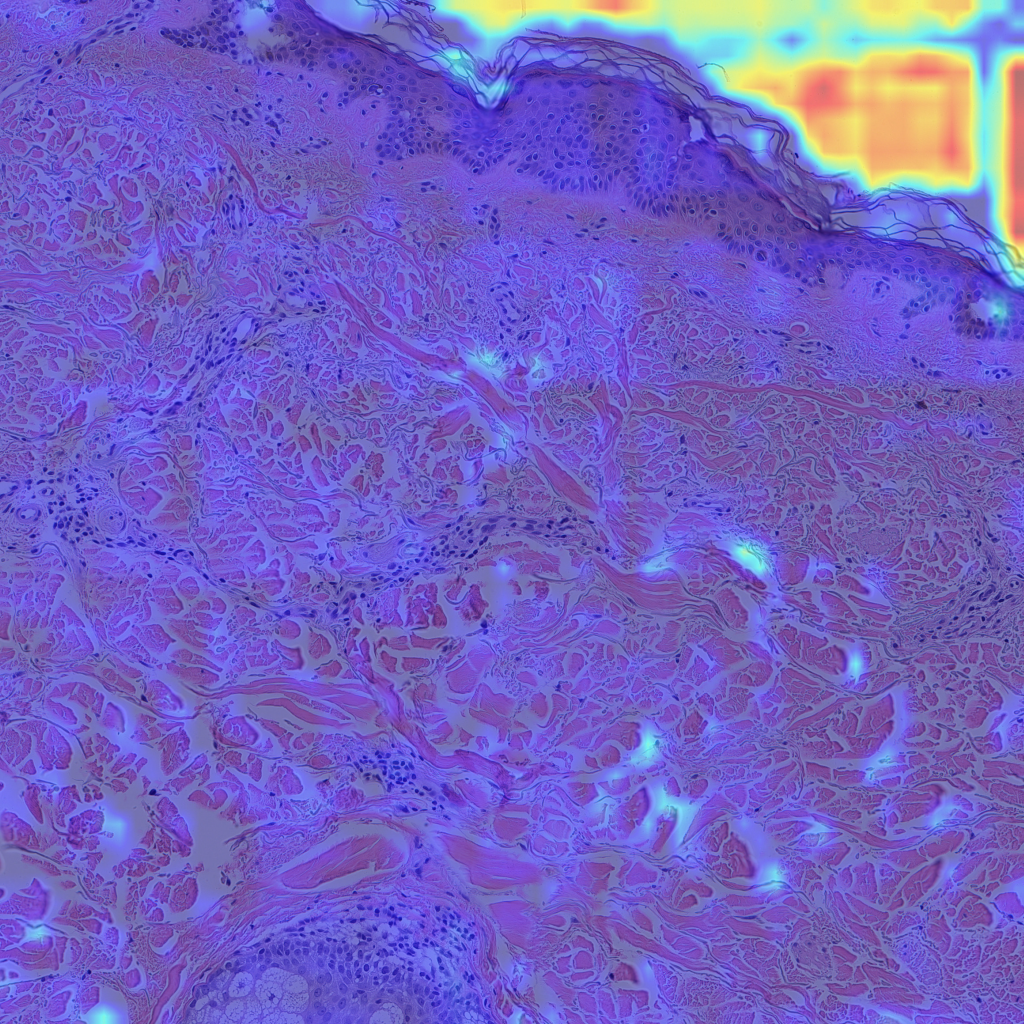

In [162]:
Image.fromarray(cam_image)

In [163]:
# save image:
save_path = r"\\10.99.68.178\Kevin\pytorch_deeplab_test_set\class_activation_map_examples"
img_name = os.path.basename(image_path[0]).split(".png")[0]
class_dict = dict({"corneum" : 1,"spinosum": 2,"hairshaft":3,"hairfollicle":4,"smoothmuscle":5,"oil":6,"sweat":7,"nerve":8,"bloodvessel":9,"ecm":10,"fat":11,"white_background":12})
keys_with_target_value = [key for key, val in class_dict.items() if val == class_category]
if keys_with_target_value:
    result_key = keys_with_target_value[0]
sub_img_name = result_key + "_" + CAMmethod + ".png"
save_path = os.path.join(save_path,img_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_path = os.path.join(save_path,sub_img_name)
Image.fromarray(cam_image).save(save_path)